In [1]:
import findspark
findspark.init()
import pyspark
import random
import warnings 
import matplotlib.pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

# sc = pyspark.SparkContext(appName="myAppName")


In [2]:
peopleFile = "C:/Users/avadavelli/Downloads/twitter-vaccination-dataset/vaccination2.csv"
reader = spark.read 
reader.option("header",True)
reader.option("inferSchema",True)
df = reader.csv(peopleFile)
df.show(2)
# df.head()
# sc.stop()

+-------------------+-------------------+-------------+----------+--------+--------------------+----------+---------------+--------------------+-----+--------------------+-----------+--------------------+------+-------------+--------------+-----------+--------+--------+--------------------+-------+---------+-----+----+----+------+----------+-------+----------+--------------------+------------+
|                 id|    conversation_id|   created_at|      date|    time|            timezone|   user_id|       username|                name|place|               tweet|   mentions|                urls|photos|replies_count|retweets_count|likes_count|hashtags|cashtags|                link|retweet|quote_url|video|near| geo|source|user_rt_id|user_rt|retweet_id|            reply_to|retweet_date|
+-------------------+-------------------+-------------+----------+--------+--------------------+----------+---------------+--------------------+-----+--------------------+-----------+--------------------+--

In [3]:
# print('Dataset size:',df.describe())
print('Columns are:',df.columns)
print('Schema: ', df.printSchema())

Columns are: ['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date']
root
 |-- id: string (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- replies_count: string (nullable = true)
 |-- retweets_count: string (nullable = true)
 

In [4]:
from pyspark.sql.types import DateType
df = df.select(df['date'].cast(DateType()), "tweet", "hashtags") 
df

DataFrame[date: date, tweet: string, hashtags: string]

In [5]:
df.show(10)

+----------+--------------------+--------------------+
|      date|               tweet|            hashtags|
+----------+--------------------+--------------------+
|2019-10-03|Thinks:  ... teta...|                  []|
|2019-10-03|Forced Vaccinatio...|                  []|
|2019-10-03|We have had our f...|                  []|
|2019-10-03|That's true, they...|                  []|
|2019-10-03|Flu vaccination d...|         ['#fluvax']|
|2019-10-03|What did farmers ...|['#tbfree', '#bad...|
|2019-10-03|An employee at Tu...|                  []|
|2019-10-03|#Nigeria: An outb...|        ['#nigeria']|
|2019-10-03|Impressive number...|['#vaccination', ...|
|2019-10-03|⁦@DrBGellin⁩ @Sab...|['#research', '#v...|
+----------+--------------------+--------------------+
only showing top 10 rows



In [6]:
import string

import nltk
from nltk.corpus import stopwords
from nltk import re
nltk.download('punkt')
nltk.download('stopwords')

MIN_YEAR = 1900
MAX_YEAR = 2100


def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')


def get_emojis_pattern():
    try:
        # UCS-4
        emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    except re.error:
        # UCS-2
        emojis_pattern = re.compile(
            u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    return emojis_pattern


def get_hashtags_pattern():
    return re.compile(r'#\w*')


def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')


def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')


def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')


def get_mentions_pattern():
    return re.compile(r'@\w*')


def is_year(text):
    if (len(text) == 3 or len(text) == 4) and (MIN_YEAR < len(text) < MAX_YEAR):
        return True
    else:
        return False


class TwitterPreprocessor:

    def __init__(self, text: str):
        self.text = text

    def fully_preprocess(self):
        return self \
            .remove_urls() \
            .remove_mentions() \
            .remove_hashtags() \
            .remove_twitter_reserved_words() \
            .remove_punctuation() \
            .remove_single_letter_words() \
            .remove_blank_spaces() \
            .remove_stopwords() \
            .remove_numbers()

    def remove_urls(self):
        self.text = re.sub(pattern=get_url_patern(), repl='', string=self.text)
        return self

    def remove_punctuation(self):
        self.text = self.text.translate(str.maketrans('', '', string.punctuation))
        return self

    def remove_mentions(self):
        self.text = re.sub(pattern=get_mentions_pattern(), repl='', string=self.text)
        return self

    def remove_hashtags(self):
        self.text = re.sub(pattern=get_hashtags_pattern(), repl='', string=self.text)
        return self

    def remove_twitter_reserved_words(self):
        self.text = re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=self.text)
        return self

    def remove_single_letter_words(self):
        self.text = re.sub(pattern=get_single_letter_words_pattern(), repl='', string=self.text)
        return self

    def remove_blank_spaces(self):
        self.text = re.sub(pattern=get_blank_spaces_pattern(), repl=' ', string=self.text)
        return self

    def remove_stopwords(self, extra_stopwords=None):
        if extra_stopwords is None:
            extra_stopwords = []
        text = nltk.word_tokenize(self.text)
        stop_words = set(stopwords.words('english'))

        new_sentence = []
        for w in text:
            if w not in stop_words and w not in extra_stopwords:
                new_sentence.append(w)
        self.text = ' '.join(new_sentence)
        return self

    def remove_numbers(self, preserve_years=False):
        text_list = self.text.split(' ')
        for text in text_list:
            if text.isnumeric():
                if preserve_years:
                    if not is_year(text):
                        text_list.remove(text)
                else:
                    text_list.remove(text)

        self.text = ' '.join(text_list)
        return self

    def lowercase(self):
        self.text = self.text.lower()
        return self

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# tweets_array = [str(row.tweet) for row in df.collect()]
# tweets_array
# Clean tweets and append to new column
tweets = [str(row.tweet) for row in df.collect()]
clean_tweets = []
for tweet in tweets:
    c = TwitterPreprocessor((tweet))
    c.fully_preprocess()
    c = c.text
    clean_tweets.append(c)
    
# df['clean_tweets'] = clean_tweets 
# df.head(5)

In [8]:
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# clean_tweets = (["foo"] * df.count())

pandas_df = pd.DataFrame(clean_tweets, columns={'clean_tweets'})
df_spark = spark.createDataFrame(pandas_df)
# df_spark.count()
df_spark.head(10)

[Row(clean_tweets='Thinks tetanus vaccination currently 😉'),
 Row(clean_tweets='Forced Vaccination Its Ties To Eugenics David Icke'),
 Row(clean_tweets='We flu vaccination protect patients staff families …'),
 Row(clean_tweets='Thats true known contraindications vaccination Docs know stuff'),
 Row(clean_tweets='Flu vaccination pregnancy safe helps protect mothers flu pregnancy helps protect babies several months bih This impoant since babies months ’ get'),
 Row(clean_tweets='What farmers make Badger Vaccination Deployment Project views changed time Our longitudinal analysis … ££ free …'),
 Row(clean_tweets='An employee Turning Stone Reso Casino Oneida County diagnosed infectious hepatitis last week forcing hurried vaccination guests workers pictwittercomhTCAB8muoj'),
 Row(clean_tweets='An outbreak yellow fever ongoing Proof vaccination required enter country If travel area consult health care professional least weeks trip protect insect bites httpowlyHCzl50wAr9b'),
 Row(clean_tweets='

In [9]:
from pyspark.sql.functions import monotonically_increasing_id
df = df.withColumn("id", monotonically_increasing_id())
df_spark = df_spark.withColumn("id", monotonically_increasing_id())
# df_spark.show()
df3 = df_spark.join(df, "id", "outer").drop("id")
df3.show()

+--------------------+----------+--------------------+--------------------+
|        clean_tweets|      date|               tweet|            hashtags|
+--------------------+----------+--------------------+--------------------+
|On Fri PM Swindon...|2019-10-03|On Fri at 2 PM: S...|                  []|
|If member SHSU co...|2019-10-03|If you are a memb...|                  []|
|The move give tee...|2019-10-03|"""The move to gi...|                   0|
|cases decision ba...|2019-10-02|#Didyouknow, in m...|['#didyouknow', '...|
|Thats helpful sin...|2019-10-01|That's it helpful...|                  []|
|Get involved Wear...|2019-10-01|Get involved this...|['#hpvpreventionw...|
|Vaccine Death Sto...|2019-10-01|Vaccine Death Sto...|                  []|
|Doctrine Original...|2019-10-01|Doctrine of Origi...|['#antigenic', '#...|
|Could someone tel...|2019-10-01|Could someone tel...|    ['#vaccination']|
|Great Many health...|2019-10-01|"Great! Many heal...|                   1|
|annual flu 

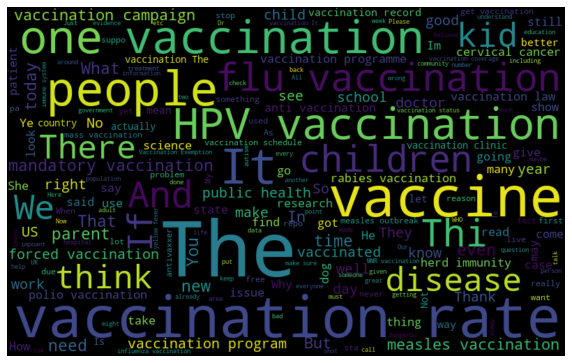

In [10]:
row_list = df3.select('clean_tweets').collect()
string_list = [ ele.__getattr__('clean_tweets') for ele in row_list]

all_words = ' '.join(string_list)
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Sentiment Analysis Using VADER

In [11]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
analyzer = SentimentIntensityAnalyzer()

(array([ 1527.,  3168.,  3478.,  4133.,  4178.,  3901.,  5497.,  3240.,
         2492., 22404.,  2999.,  2197.,  3928.,  4735.,  6192.,  3927.,
         4305.,  3652.,  2928.,  1097.]),
 array([-0.9887 , -0.88971, -0.79072, -0.69173, -0.59274, -0.49375,
        -0.39476, -0.29577, -0.19678, -0.09779,  0.0012 ,  0.10019,
         0.19918,  0.29817,  0.39716,  0.49615,  0.59514,  0.69413,
         0.79312,  0.89211,  0.9911 ]),
 <a list of 20 Patch objects>)

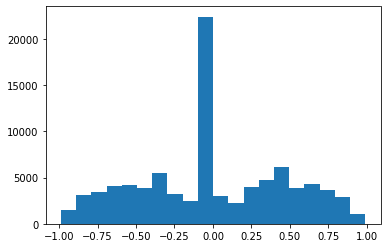

In [14]:
# create analyzer object 
# get a list of scores and plot
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in string_list]
plt.hist(scores, bins=20)

In [15]:
from pyspark.sql.functions import udf
compound = udf(lambda x: analyzer.polarity_scores(x)['compound'])
pos = udf(lambda x: analyzer.polarity_scores(x)['pos'])
neu = udf(lambda x: analyzer.polarity_scores(x)['neu'])
neg = udf(lambda x: analyzer.polarity_scores(x)['neg'])

sentiment = df3.withColumn('compound', compound('clean_tweets'))
sentiment = sentiment.withColumn('pos', pos('clean_tweets'))
sentiment = sentiment.withColumn('neu', neu('clean_tweets'))
sentiment = sentiment.withColumn('neg', neg('clean_tweets'))

sentiment.head(5)
# df = pd.concat([df,sentiment.apply(pd.Series)],1)
# df.head(5)

[Row(clean_tweets='On Fri PM Swindon Borough Council Staff Flu Vaccination ATTACHMENT LEAD TRAINING SCHOOLS DAY LOUISE BOMBER COMPANY Ad Astra Hustlers Kitchen The Rambo Last Blood …', date=datetime.date(2019, 10, 3), tweet='On Fri at 2 PM: Swindon Borough Council Staff Flu Vaccination, ATTACHMENT LEAD TRAINING for SCHOOLS DAY 1 of 7 2019-2020 LOUISE BOMBER COMPANY, Ad Astra, Hustlers, Kitchen, The, Rambo: Last Blood  http://swindonguide.org.uk/calendar/2019/10#2019-10-04\xa0…', hashtags='[]', compound='0.0857', pos='0.103', neu='0.806', neg='0.091'),
 Row(clean_tweets='If member SHSU community asthma diabetes andor history smoking vaping encourage attend special immunization clinic receive flu pneumonia vaccination Complete signup form reserve spot … pictwittercomkv212lVPH1', date=datetime.date(2019, 10, 3), tweet='If you are a member of the SHSU community w/ asthma, diabetes and/or a history of smoking or vaping we encourage you to attend a special immunization clinic to receive your

In [16]:
senti = sentiment.select('compound', 'pos', 'neu', 'neg')

In [17]:
senti

DataFrame[compound: string, pos: string, neu: string, neg: string]

In [18]:
from pyspark.sql.functions import col
senti.select(*(col(c).cast("float").alias(c) for c in senti.columns))

DataFrame[compound: float, pos: float, neu: float, neg: float]

In [20]:
senti.head(5)

[Row(compound='0.0857', pos='0.103', neu='0.806', neg='0.091'),
 Row(compound='0.5267', pos='0.196', neu='0.719', neg='0.085'),
 Row(compound='0.3612', pos='0.241', neu='0.759', neg='0.0'),
 Row(compound='0.0', pos='0.0', neu='1.0', neg='0.0'),
 Row(compound='0.2732', pos='0.202', neu='0.655', neg='0.142')]

In [ ]:
# senti.describe()